In [8]:
# Standard library imports
import re
import string
import csv
import warnings
from io import StringIO
from collections import Counter
from datetime import datetime as dt

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import emoji
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from textblob import TextBlob

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sastrawi imports (Indonesian NLP)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Google Play Scraper
from google_play_scraper import app, reviews, Sort, reviews_all

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    HistGradientBoostingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Other ML libraries
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Pandas and warnings settings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fajar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
seed = 42
np.random.seed(42)

In [10]:
# Scrapping
scrapreview = reviews_all(
    'id.go.pajak.djp',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT, 
    count=5000
)

with open('data_scrapping_content.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [11]:
# Konversi ke DataFrame
df_djp = pd.DataFrame(scrapreview)

In [12]:
df_djp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4714 entries, 0 to 4713
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              4714 non-null   object        
 1   userName              4714 non-null   object        
 2   userImage             4714 non-null   object        
 3   content               4714 non-null   object        
 4   score                 4714 non-null   int64         
 5   thumbsUpCount         4714 non-null   int64         
 6   reviewCreatedVersion  3631 non-null   object        
 7   at                    4714 non-null   datetime64[ns]
 8   replyContent          12 non-null     object        
 9   repliedAt             12 non-null     datetime64[ns]
 10  appVersion            3631 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 405.2+ KB


In [13]:
df_djp = pd.DataFrame(scrapreview).to_csv('data_scrapping_full.csv', index=False)

In [7]:
# Rename columns
df.rename(columns={'content': 'Text'}, inplace=True)
df.head()

,Text
0,"Mau aplikasi, situs web, atau instansi lainnya..."
1,"Aplikasi nggak berguna,saya sudah 3 jam mengak..."
2,"Lupa efin di suruh lewat m pajak , udh di coba..."
3,"Semakin parah aplikasi djp, buat dari websitep..."
4,Sudah coba login aplikasi pakai password yang ...


In [8]:
df.duplicated().sum()

458

In [9]:
df = df.drop_duplicates()

In [10]:
df.isnull().sum()

Text    0
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.shape

(4256, 1)

In [13]:
# Lowercase text
df['Text Casefold'] = df['Text'].str.lower()
df.head()

,Text,Text Casefold
0,"Mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya..."
1,"Aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak..."
2,"Lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba..."
3,"Semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep..."
4,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...


In [14]:
# Remove HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

df['Text Clean'] = df['Text Casefold'].apply(remove_html_tags)
df.head()

,Text,Text Casefold,Text Clean
0,"Mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya..."
1,"Aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak..."
2,"Lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba..."
3,"Semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep..."
4,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...


In [15]:

def regex(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
 
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefolding(text):
    text = text.lower()
    return text
 
def tokenizing(text):
    return text.split() 
 
def stopword(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(
        ['iya','yaa','gak','nya','na','sih','ku',
         "di","ga","ya","gaa","loh","kah","woi","woii","woy", "dah"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [16]:
slangwords = {"abis": "habis", 
              "wtb": "beli", 
              "masi": "masih", 
              "wts": "jual", 
              "wtt": "tukar", 
              "bgt": "banget", 
              "maks": "maksimal",
              "aja": "saja",
              "apk": "aplikasi",
              "gk": "tidak",
              "udah": "sudah",
              "yg": "yang",
              "aplikasinya": "aplikasi",
              "banget": "sangat",
              "bikin": "buat",
              "ribet": "susah",
              "ok": "oke",
              "oc": "oke",
              "oce": "oke",
              "jg": "juga",
              "jgn": "jangan",
              "kalo": "kalau",
              "gimana": "bagaimana",
              }
def slangword(text):
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [17]:
# regex
df['text_clean'] = df['Text'].apply(regex)
# casefolding
df['text_casefolding'] = df['text_clean'].apply(casefolding)
# slang
df['text_slangwords'] = df['text_casefolding'].apply(slangword)
# tokenize
df['text_tokenizing'] = df['text_slangwords'].apply(tokenizing)
# stopword
df['text_stopword'] = df['text_tokenizing'].apply(stopword)

df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [18]:
df.head()

,Text,Text Casefold,Text Clean,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,text_akhir
0,"Mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya...",Mau aplikasi situs web atau instansi lainnya y...,mau aplikasi situs web atau instansi lainnya y...,mau aplikasi situs web atau instansi lainnya y...,"[mau, aplikasi, situs, web, atau, instansi, la...","[aplikasi, situs, web, instansi, berhubungan, ...",aplikasi situs web instansi berhubungan pemeri...
1,"Aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak...",Aplikasi nggak bergunasaya sudah jam mengakse...,aplikasi nggak bergunasaya sudah jam mengakse...,aplikasi nggak bergunasaya sudah jam mengakses...,"[aplikasi, nggak, bergunasaya, sudah, jam, men...","[aplikasi, nggak, bergunasaya, jam, mengakses,...",aplikasi nggak bergunasaya jam mengakses live ...
2,"Lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba...",Lupa efin di suruh lewat m pajak udh di coba ...,lupa efin di suruh lewat m pajak udh di coba ...,lupa efin di suruh lewat m pajak udh di coba t...,"[lupa, efin, di, suruh, lewat, m, pajak, udh, ...","[lupa, efin, suruh, pajak, udh, coba, tpi, pas...",lupa efin suruh pajak udh coba tpi pas ajuin p...
3,"Semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep...",Semakin parah aplikasi djp buat dari websitepu...,semakin parah aplikasi djp buat dari websitepu...,semakin parah aplikasi djp buat dari websitepu...,"[semakin, parah, aplikasi, djp, buat, dari, we...","[parah, aplikasi, djp, websitepun, kode, verif...",parah aplikasi djp websitepun kode verifikasi ...
4,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,"[sudah, coba, login, aplikasi, pakai, password...","[coba, login, aplikasi, pakai, password, verif...",coba login aplikasi pakai password verifikasi ...


In [19]:
# Empty Strings 
num_empty_text = (df['text_akhir'] == '').sum()

print(f"Jumlah baris sebelum pembersihan: {len(df)}")

print(f"Jumlah baris dengan Text kosong: {num_empty_text}")

df = df[df['text_akhir'] != ''].reset_index(drop=True)

print(f"Jumlah baris setelah pembersihan: {len(df)}")



Jumlah baris sebelum pembersihan: 4256
Jumlah baris dengan Text kosong: 50
Jumlah baris setelah pembersihan: 4206


In [20]:
# Labeling
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [21]:

# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    return score, polarity

In [22]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
negative    3088
positive    1118
Name: count, dtype: int64


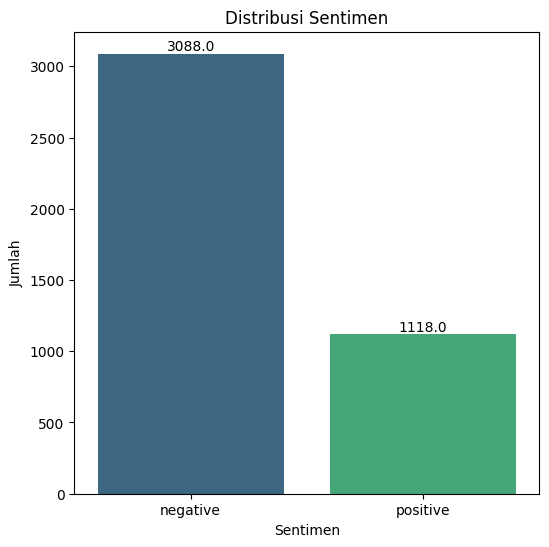

In [23]:
plt.figure(figsize=(6,6))
ax = sns.countplot(x=df['polarity'], palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.title("Distribusi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")

plt.show()

In [24]:
df

,Text,Text Casefold,Text Clean,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,text_akhir,polarity_score,polarity
0,"Mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya...","mau aplikasi, situs web, atau instansi lainnya...",Mau aplikasi situs web atau instansi lainnya y...,mau aplikasi situs web atau instansi lainnya y...,mau aplikasi situs web atau instansi lainnya y...,"[mau, aplikasi, situs, web, atau, instansi, la...","[aplikasi, situs, web, instansi, berhubungan, ...",aplikasi situs web instansi berhubungan pemeri...,-22,negative
1,"Aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak...","aplikasi nggak berguna,saya sudah 3 jam mengak...",Aplikasi nggak bergunasaya sudah jam mengakse...,aplikasi nggak bergunasaya sudah jam mengakse...,aplikasi nggak bergunasaya sudah jam mengakses...,"[aplikasi, nggak, bergunasaya, sudah, jam, men...","[aplikasi, nggak, bergunasaya, jam, mengakses,...",aplikasi nggak bergunasaya jam mengakses live ...,-1,negative
2,"Lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba...","lupa efin di suruh lewat m pajak , udh di coba...",Lupa efin di suruh lewat m pajak udh di coba ...,lupa efin di suruh lewat m pajak udh di coba ...,lupa efin di suruh lewat m pajak udh di coba t...,"[lupa, efin, di, suruh, lewat, m, pajak, udh, ...","[lupa, efin, suruh, pajak, udh, coba, tpi, pas...",lupa efin suruh pajak udh coba tpi pas ajuin p...,-18,negative
3,"Semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep...","semakin parah aplikasi djp, buat dari websitep...",Semakin parah aplikasi djp buat dari websitepu...,semakin parah aplikasi djp buat dari websitepu...,semakin parah aplikasi djp buat dari websitepu...,"[semakin, parah, aplikasi, djp, buat, dari, we...","[parah, aplikasi, djp, websitepun, kode, verif...",parah aplikasi djp websitepun kode verifikasi ...,-19,negative
4,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,Sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,sudah coba login aplikasi pakai password yang ...,"[sudah, coba, login, aplikasi, pakai, password...","[coba, login, aplikasi, pakai, password, verif...",coba login aplikasi pakai password verifikasi ...,-13,negative
...,...,...,...,...,...,...,...,...,...,...,...
4201,Ok nyaman,ok nyaman,ok nyaman,Ok nyaman,ok nyaman,oke nyaman,"[oke, nyaman]","[oke, nyaman]",oke nyaman,6,positive
4202,mantap aplikasi,mantap aplikasi,mantap aplikasi,mantap aplikasi,mantap aplikasi,mantap aplikasi,"[mantap, aplikasi]","[mantap, aplikasi]",mantap aplikasi,1,positive
4203,Jos banget ..........,jos banget ..........,jos banget ..........,Jos banget,jos banget,jos sangat,"[jos, sangat]",[jos],jos,0,positive
4204,Oke😊😊😊,oke😊😊😊,oke😊😊😊,Oke,oke,oke,[oke],[oke],oke,2,positive


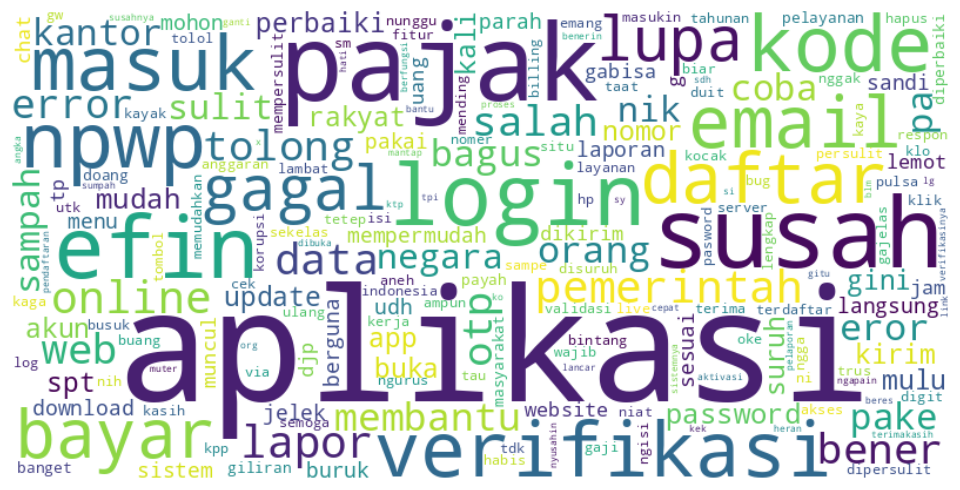

In [25]:
# Wordcloud
text = ' '.join([' '.join(tokens) for tokens in df['text_stopword']])

wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    collocations=False,  
    random_state=42,
    ).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

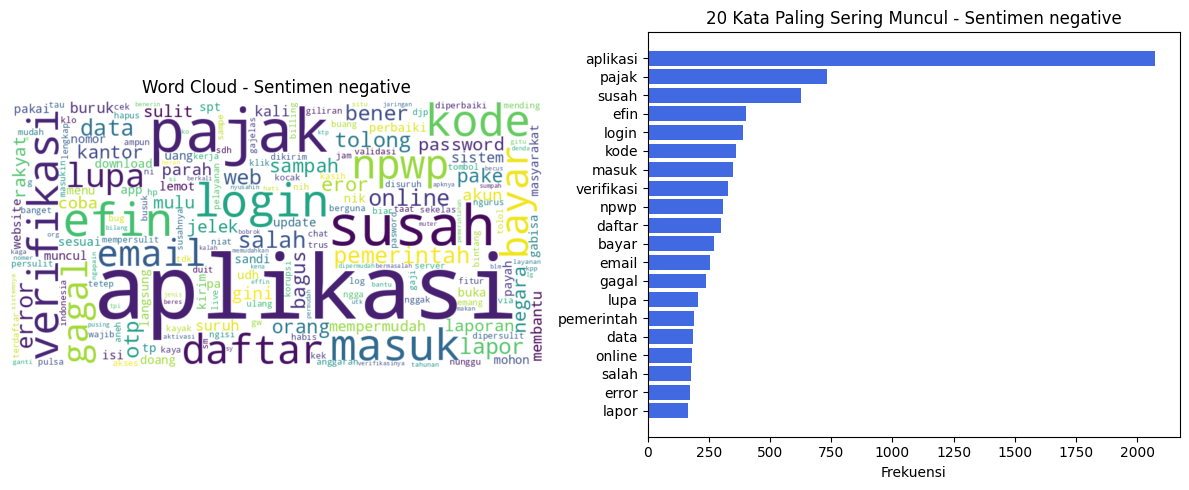

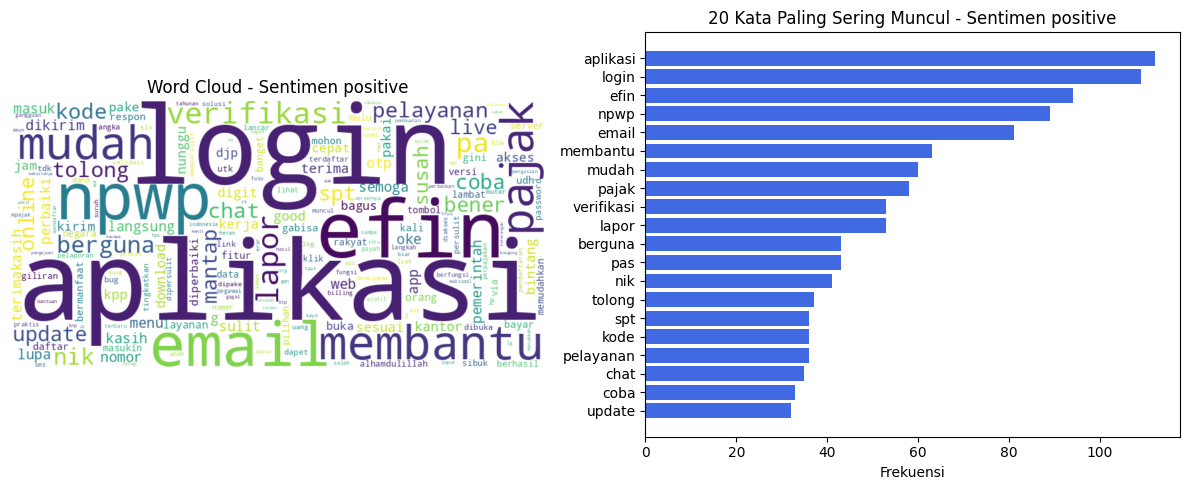

In [26]:
def plot_wordcloud_and_top_words(df, sentiment_label):
    text = ' '.join([' '.join(tokens) for tokens in df[df['polarity'] == sentiment_label]['text_stopword']])

    wordcloud = WordCloud(
        width=800, height=400, 
        background_color='white', 
        colormap='viridis',
        collocations=False, 
        random_state=42,
    ).generate(text)

    words = text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(20)

    plt.figure(figsize=(12, 5))
    
    # Word Cloud
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud - Sentimen {sentiment_label}")

    # Top 20 Words Bar Chart
    plt.subplot(1, 2, 2)
    words, counts = zip(*most_common_words)
    words = [word.strip("'") for word in words]
    plt.barh(words[::-1], counts[::-1], color='royalblue')
    plt.xlabel("Frekuensi")
    plt.title(f"20 Kata Paling Sering Muncul - Sentimen {sentiment_label}")

    plt.tight_layout()
    plt.show()

# Loop
for sentiment in df['polarity'].unique():
    plot_wordcloud_and_top_words(df, sentiment)

In [27]:
# df.to_excel("cek kata.xlsx", index=False)


In [28]:
X = df['text_akhir']
y = df['polarity']

tfidf = TfidfVectorizer(
    max_features=500,
    min_df=10,
    max_df=0.9,
    ngram_range=(1, 3),
    sublinear_tf=True,
    use_idf=True,
    norm='l2'
)

X_tfidf = tfidf.fit_transform(X)

if len(np.unique(y)) > 1 and min(Counter(y).values()) / max(Counter(y).values()) < 0.7:
    print("Applying SMOTE for class balancing")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)
else:
    X_resampled, y_resampled = X_tfidf, y

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

Applying SMOTE for class balancing


In [29]:
# Hyperparameter Tuning and Model Evaluation

models = {
    'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ),
    'CatBoost': CatBoostClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        depth=6,
        verbose=0, 
        random_state=42
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    ),
    'SVM': SVC(
        C=1.0,
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        verbose=-1
    ),
    'Passive Aggressive': PassiveAggressiveClassifier(
        C=1.0,
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'Ridge Classifier': RidgeClassifier(
        alpha=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        class_weight='balanced'
    )
}

results = []
X_train_array = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test_array = X_test.toarray() if hasattr(X_test, "toarray") else X_test

for name, model in models.items():
    # Train
    model.fit(X_train_array, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train_array)
    y_pred_test = model.predict(X_test_array)
    
    # Evaluate
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    # Store detailed metrics
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    results.append({
        'Model': name,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1 Score': report['weighted avg']['f1-score'],
        'Difference': accuracy_train - accuracy_test
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

In [30]:
results_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Difference
0,SVM,0.985223,0.961974,0.962033,0.961974,0.961973,0.023249
1,Extra Trees,0.990688,0.959547,0.959552,0.959547,0.959547,0.031141
2,Random Forest,0.990688,0.940939,0.940967,0.940939,0.940938,0.049750
3,Logistic Regression,0.942308,0.932848,0.934405,0.932848,0.932788,0.009460
4,LightGBM,0.954049,0.927184,0.927830,0.927184,0.927157,0.026864
5,Ridge Classifier,0.948988,0.926375,0.928856,0.926375,0.926269,0.022612
6,CatBoost,0.958502,0.925566,0.926106,0.925566,0.925543,0.032936
7,Gradient Boosting,0.978543,0.922330,0.922689,0.922330,0.922314,0.056212
8,Passive Aggressive,0.945344,0.915049,0.923052,0.915049,0.914645,0.030296
9,Decision Tree,0.990688,0.906149,0.907108,0.906149,0.906094,0.084539


In [31]:
# Tunning Best Model
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print(f"Best parameters for SVM: {grid_svm.best_params_}")

best_svm = grid_svm.best_estimator_

best_svm.fit(X_train.toarray(), y_train)

y_pred_train_svm = best_svm.predict(X_train.toarray())
y_pred_test_svm = best_svm.predict(X_test.toarray())

accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - accuracy_train: 0.9902834008097166
SVM - accuracy_test: 0.9692556634304207
